## HistoCell: Weakly-supervised deep learning framework for hierarchical spatial cellular information prediction

### Preprocess

We illustrate the image-tiling process for histopathology images in ST data.

In [63]:
import cv2
import numpy as np
from PIL import Image

def create_tile(ori_image: np.array, save_path: str, center_x: int, center_y: int, cut_size, output_size=None) -> None:
    upper = center_x - cut_size[0] // 2
    left = center_y - cut_size[1] // 2
    
    ### 02-12 update
    upper = max(0, upper)
    left = max(0, left)
    ###
    
    tile = ori_image[upper:upper+cut_size[0], left:left+cut_size[1], ::-1] # cv2 is BGR while input is RGB
    if output_size is not None:
        tile = cv2.resize(tile, dsize=(output_size[0], output_size[1]), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(save_path, tile)

def load_image(img_path):
    fp = open(img_path, 'rb')
    pic = Image.open(fp)
    pic = np.array(pic)
    fp.close()
    return pic

def load_full_image(img_path):
    Image.MAX_IMAGE_PIXELS = None
    original_image = load_image(img_path)
    return original_image

In [64]:
import pandas as pd
import cv2

sample_name = '10x_BRCA'
tile_save_dir = './data/cell_state/tiles'   # Path to save
image_path = './data/cell_state/Visium_FFPE_Human_Breast_Cancer_image.tif'  # The raw high resolution image
height, width = 252, 291    # Fix it according to your data

tissue_positions = pd.read_csv('./data/cell_state/tissue_positions_list.csv')   # Tissue position list
print(f"Loading {sample_name}...")
full_image = load_full_image(image_path)
print(full_image.shape)
image = full_image.copy()

valid_positions = tissue_positions[tissue_positions['in_tissue'] == 1]
print(f'##### Tiles Saved in {tile_save_dir} #####')
os.makedirs(tile_save_dir, exist_ok=True)

for idx, coordinates in valid_positions.iterrows():
    index = "%06d" %idx
    x, y, pixel_x, pixel_y = int(coordinates['array_row']), int(coordinates['array_col']), int(coordinates['pxl_row_in_fullres']), int(coordinates['pxl_col_in_fullres'])
    create_tile(full_image, os.path.join(tile_save_dir, f"{index}_{x}x{y}.jpg"), center_x=pixel_x, center_y=pixel_y, cut_size=[height, width])

Loading 10x_BRCA...
(25233, 27452, 3)
##### Tiles Saved in ./data/cell_state/tiles #####


### Model Inference
Here, we only illustrate the postprocess part and the representative results. The training and entire inference code will be released soon.

#### Functions

In [8]:
import cv2
import numpy as np
from PIL import Image

def load_image(img_path):
    fp = open(img_path, 'rb')
    pic = Image.open(fp)
    pic = np.array(pic)
    fp.close()
    return pic

def load_full_image(img_path):
    Image.MAX_IMAGE_PIXELS = None
    original_image = load_image(img_path)
    return original_image

def Bayesian_cell_type(cell_types, probs, immune_list):
    final_prob_list = []
    for cell_type, prob in zip(cell_types, probs):
        if cell_type == 0:
            final_prob_list.append('Cancer Epithelial')
        elif cell_type == 2:
            final_prob_list.append('Stromal')
        else:
            # new_prob = np.zeros_like(prob)
            # new_prob[0] = 0
            # new_prob[5] = 0
            # print(np.argmax(new_prob))
            final_prob_list.append('Immune Cells')
    return final_prob_list

def load_json(json_path):
    with open(json_path, 'r', encoding='utf-8') as file:
        nuc_info = json.load(file)

    return nuc_info['nuc']

#### Tissue Compartment

(-0.5, 579.5, 613.5, -0.5)

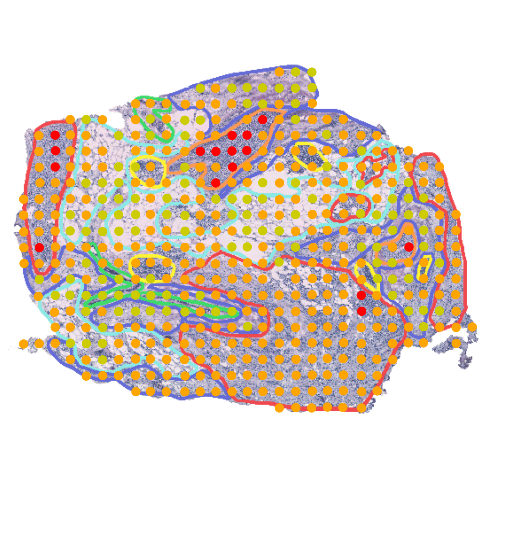

In [7]:
import pandas as pd
import os
import pickle as pkl
from glob import glob
from matplotlib import pyplot as plt

# Parameters
tc_dict = {"0": "TME", "1": "Epi", "2": "TME", "3": "TME", "4": "TME", "5": "TME"}
mixture_threshold = 0.6
scatter_dict = {"Epi": 'red', 'TME': "#CCCC00", 'Mix': "orange"}
scale_factor = 10

# Load Data
tissue_positions = pd.read_csv('./data/tissue_compartment/G2_ann.tsv', sep='\t')
full_image = load_full_image('./data/tissue_compartment/G2_annotated.png')
image = full_image.copy()
image = cv2.resize(image, (int(full_image.shape[1] / scale_factor), int(full_image.shape[0] / scale_factor)))
cell_prop = pd.read_csv("./data/tissue_compartment/G2_prop.tsv", sep='\t', index_col=0)

# Plotting
tissue_compartments, plt_x, plt_y = [], [], []
for idx, coordinates in tissue_positions.iterrows():
    index = "%06d" %idx
    x, y, pixel_x, pixel_y = int(coordinates['x']), int(coordinates['y']), coordinates['ann_x'], coordinates['ann_y']

    sample_key = f"{x}x{y}"
    if sample_key not in cell_prop.index:
        continue
    
    cell_num = np.array(cell_prop.loc[sample_key])
    cp = cell_num / np.sum(cell_num)

    if np.max(cp) > mixture_threshold:
        tissue_compartments.append(scatter_dict[tc_dict[str(np.argmax(cp))]])
    else:
        tissue_compartments.append(scatter_dict['Mix'])
    plt_x.append(pixel_x / scale_factor)
    plt_y.append(pixel_y / scale_factor)
plt.figure(figsize=(14, 10))
plt.imshow(image, alpha=0.8)
sc = plt.scatter(plt_x, plt_y, s=60, c=tissue_compartments)
plt.axis('off')

#### Single-cell type

In [2]:
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt

file_path = './data/H1_hires.pkl'
with open(file_path, 'rb') as file:
    val_results = pkl.load(file)

for key, value in val_results.items():
    print(key)
    print(value.keys())
    break

H1_hires_003061_49x23
dict_keys(['prob', 'pred_proportion', 'prior_type', 'cell_num', 'cell_coords'])


(182.0, 9334.0, -10109.0, -1661.0)

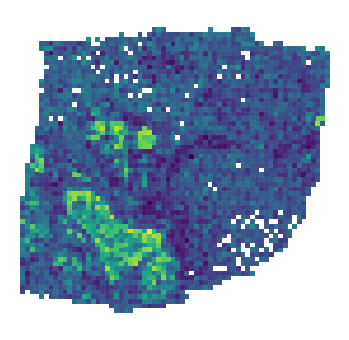

In [13]:
# Cell proportion illustration
# 0: B Cells, 1: Cancer Epithelial, 2: Myeloid, 3: Plasmablasts, 4: Stromal Cells, 5: T Cells 
with open('./data/mapping_coords.pkl', 'rb') as mc:
    mapped_dict = pkl.load(mc)
x_list, y_list, prop_list = [], [], []
for idx_key, value in val_results.items():
    sample_name, reso, id, xy = idx_key.split('_')
    pixel_xy = mapped_dict[xy]
    x_list.append(pixel_xy[0]), y_list.append(pixel_xy[1]), prop_list.append(value['pred_proportion'][1])
x_array, y_array = np.array(x_list), np.array(y_list)
prop_array = np.array(prop_list)

plt.figure(figsize=(6, 6))
plt.scatter(x_array, -y_array, c=prop_array, marker='s', s=15)
plt.axis('off')
plt.axis('equal')

(-0.5, 409.5, 409.5, -0.5)

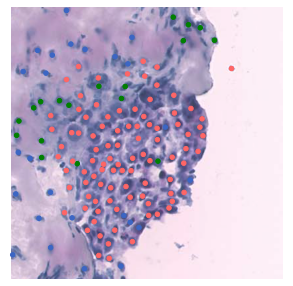

In [28]:
import os
import pandas as pd

full_image = load_full_image('./data/HE_BT24044_D2.jpg')
cell_coord_list, prob_list, post_prob_list = [], [], []
normalized_conditional_mat = np.array(pd.read_csv('./data/conditional_prob_H1.tsv', index_col=0, sep='\t'))
roi_left, roi_right, roi_top, roi_bottom = 4300, 4700, 8500, 8900

for idx_key, value in val_results.items():
    sample_name, reso, id, xy = idx_key.split('_')
    pixel_xy = mapped_dict[xy]
    pred_prob = value['prob']
    cell_coords = value['cell_coords'] + np.array(pixel_xy) - 64
    cell_coord_list.append(cell_coords)
    prob_list.append(pred_prob)
    new_prob = np.zeros_like(pred_prob)
    for idx, (prob, prior_type) in enumerate(zip(pred_prob, value['prior_type'])):
        new_prob[idx] = prob * normalized_conditional_mat[:, prior_type]
    post_prob_list.append(new_prob)

cell_coord_mat = np.concatenate(cell_coord_list, axis=0)
cell_prob_mat = np.concatenate(prob_list, axis=0)
post_prob_mat = np.concatenate(post_prob_list, axis=0)

sub_coord_list, sub_prob_list = [], []
for coord, prob in zip(cell_coord_mat, post_prob_mat):
    if roi_left <= coord[1] <= roi_right and roi_top <= coord[0] <= roi_bottom:
        sub_coord_list.append(coord)
        sub_prob_list.append(prob)

sub_coord_mat = np.stack(sub_coord_list, axis=0)
sub_prob_mat = np.stack(sub_prob_list, axis=0)

color_list = ["#CCCC00", "#FF6666", "#87CEFA", "#3C66C4", "#008000", "#FFA500"]
plt_c_list = [color_list[np.argmax(item)] for item in sub_prob_mat]
plt.figure(figsize=(5, 5))
plt.imshow(full_image[roi_left: roi_right + 10, roi_top: roi_bottom + 10], alpha=0.8)
plt.scatter(sub_coord_mat[:, 0] - roi_top, sub_coord_mat[:, 1] - roi_left, c=plt_c_list, s=20)
plt.axis('off')
plt.axis('equal')

#### Cell States

/home/gcf22/miniconda3/envs/gcf/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/gcf22/miniconda3/envs/gcf/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(-0.5, 849.5, 849.5, -0.5)

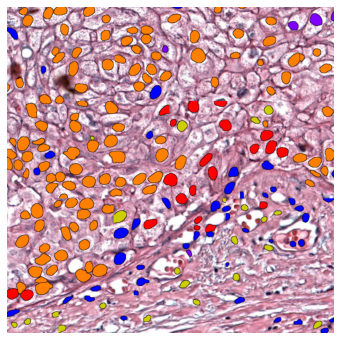

In [65]:
import pandas as pd
import os
import pickle as pkl
import cv2

# Parameters
label_list = ['Stromal', 'B_cells', 'T_cells', 'Myeloid', 'Plasmablasts', 'Cancer_epithelial']
color_list = [(255, 75, 145), (64, 128, 64), (255,0,0), (0, 0, 0), (255, 128, 0), (128, 0, 255)]
json_dir = './data/cell_state/10x_BRCA_seg/'
res_file = './data/cell_state/10x_BRCA_states.pkl'
# ROI
x1, y1 = 13600, 20800 - 1024
dx, dy = 1500, 1300
x2, y2 = x1 + dx, y1 + dy
width, height = 292, 253

with open(res_file, 'rb') as file:
    res_dict = pkl.load(file)
tissue_positions = pd.read_csv('./data/cell_state/tissue_positions_list.csv', index_col=0)
full_image = load_full_image('./data/cell_state/Visium_FFPE_Human_Breast_Cancer_image.tif')

background = np.zeros([dy, dx, 3], dtype=np.int)
# background = full_image[y1:y2, x1:x2].copy()
base_x_list, base_y_list, epi_state_list = [], [], []
x_list, y_list = [], []
for spot_name, spot_info in res_dict.items():
    spot_id = spot_name.split('10x_BRCA_')[-1]
    temp_x, temp_y = spot_id.split('_')[-1].split('x')
    temp_x, temp_y = int(temp_x), int(temp_y)
    base_x = int(tissue_positions[tissue_positions['array_row'] == temp_x][tissue_positions['array_col'] == temp_y][['pxl_row_in_fullres']].iloc[0])
    base_y = int(tissue_positions[tissue_positions['array_row'] == temp_x][tissue_positions['array_col'] == temp_y][['pxl_col_in_fullres']].iloc[0])
    if base_x - height//2 >= y1 and base_x + height//2 <= y2 and base_y + width//2 <= x2 and base_y - width//2 >= x1:
        new_cell_type = Bayesian_cell_type(spot_info['prior_type'], spot_info['cell_prob'], immune_list=label_list)
        json_path = os.path.join(json_dir, f"{spot_id}.json")
        seg_info = load_json(json_path)
        image = load_image(f"./data/cell_state/tiles/{spot_id}.jpg")
        center_x = base_y - x1 - width // 2
        center_y = base_x - y1 - height // 2
        for cell_type, state_type_prob, cell_info in zip(new_cell_type, spot_info['state_prob'], seg_info.values()):
            if cell_type in ['Cancer Epithelial']:
                cancer_epi_state = np.argmax(state_type_prob[5:], axis=-1)
                cell_contour = np.array(cell_info['contour'], dtype=np.int)
                cv2.drawContours(image, [cell_contour], -1, (0, 0, 0), 2)
                cv2.drawContours(image, [cell_contour], -1, color_list[cancer_epi_state], cv2.FILLED)
                
            elif cell_type in ['Stromal']:
                cell_contour = np.array(cell_info['contour'], dtype=np.int)
                cv2.drawContours(image, [cell_contour], -1, (0, 0, 0), 2)
                cv2.drawContours(image, [cell_contour], -1, (0, 0, 255), cv2.FILLED)

            else:
                cell_contour = np.array(cell_info['contour'], dtype=np.int)
                cv2.drawContours(image, [cell_contour], -1, (0, 0, 0), 2)
                cv2.drawContours(image, [cell_contour], -1, (205,205,0), cv2.FILLED)

        base_x_list.append(base_x), base_y_list.append(base_y)
        background[center_y: center_y + height, center_x: center_x + width] = cv2.resize(image, (width, height))

plt.figure(figsize=(6, 6))
plt.imshow(background[150:1000, 250:1100])
plt.axis('off')

#### Spatial Biomarker Identification

The code of feature extraction will be released soon.

##### Survial Analysis

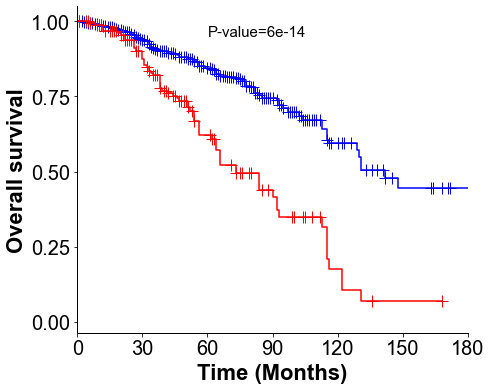

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from lifelines import KaplanMeierFitter

from lifelines.statistics import logrank_test

# Load clinical data and Spatial Features
clinical_df = pd.read_csv("./data/spatial_biomarker_identification/SpatialFeatures.csv", index_col=0)
clinical_df = clinical_df.dropna()

# Day to Month
survival_df = clinical_df.copy()
survival_df['os.time'] = (np.array(survival_df['os.time']) / 30).astype(np.int)
survival_df = survival_df[survival_df['os.time'] >= 1]
font_dict = dict(fontsize=22, color='black', family='Arial', weight='bold')

# KM Analysis
i = 109
groups = np.array(survival_df[str(i)])
fig, ax = plt.subplots(figsize=(7, 6))

i1 = (groups >= np.median(groups))
i2 = (groups < np.median(groups))

kmf1 = KaplanMeierFitter()
kmf1.fit(survival_df['os.time'][i1], survival_df['os.state'][i1], label='High Value Group')
a1 = kmf1.plot(color='blue', show_censors=True, ci_alpha=0)
kmf1.fit(survival_df['os.time'][i2], survival_df['os.state'][i2], label='Low Value Group')
result = logrank_test(survival_df['os.time'][i1], survival_df['os.time'][i2], survival_df['os.state'][i1], survival_df['os.state'][i2])
kmf1.plot(ax=a1, color='red', show_censors=True, ci_alpha=0)
plt.xlim([0, 180])
plt.xticks([0, 30, 60, 90, 120, 150, 180], fontsize=20, fontfamily='Arial')
plt.yticks([0.00, 0.25, 0.50, 0.75, 1.00], fontsize=20, fontfamily='Arial')
plt.xlabel('Time (Months)', fontdict=font_dict)
plt.ylabel("Overall survival", fontdict=font_dict)
plt.legend().remove()
plt.text(60, 0.95, f'P-value={round(result.p_value, 14)}', fontsize=15, family='Arial')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

##### Demo

In [71]:
import os
import pickle as pkl
import json

def generate_cell_info_for_single_spot(sample_name, key, value, normalized_conditional_mat, json_dir='./data'):
    base_x, base_y = key.split('_')[-1].split('x')
    base_x, base_y = int(base_x), int(base_y)
    json_name = os.path.join(
        json_dir, sample_name, 'json', key.split("_")[1] + "_" + key.split("_")[2] +".json"
    )
    with open(json_name, 'r') as json_file:
        json_data = json.load(json_file)

    probs = value['prob']
    prior_types = value['prior_type']
    new_prob = np.zeros_like(probs)
    for idx, (prob, prior_type) in enumerate(zip(probs, prior_types)):
        new_prob[idx] = prob * normalized_conditional_mat[:, prior_type]
        # new_prob[idx] = prob
    new_prob = new_prob / np.sum(new_prob, axis=-1, keepdims=True)

    json_center = [value["centroid"] for key, value in json_data["nuc"].items()]
    json_center = np.array(json_center) + np.array([base_x, base_y])
    json_border = [value["contour"] for key, value in json_data["nuc"].items()]
    json_border = [np.array([[int(x) + base_x, int(y) + base_y] for x, y in sublist]) for sublist in json_border]

    type_array = np.argmax(new_prob, axis=-1)
    return json_center, json_border, type_array

In [72]:
# Visualization Demo
import openslide
import numpy as np
from matplotlib import pyplot as plt

root_dir = './data/spatial_biomarker_identification/demo'
slide_path = './data/spatial_biomarker_identification/demo/TCGA-A2-A0EN-01A-01-TSA.d57caa16-813c-41c9-9b9a-3e906e576bb0.svs'
sample_name = slide_path.split('/')[-1].split('.')[0]
cell_path = f'./data/spatial_biomarker_identification/demo/epoch_60_{sample_name}.pkl'

df = pd.read_csv('./data/spatial_biomarker_identification/demo/conditional_prob_ABCD10x.tsv', sep='\t', index_col=0)
normalized_conditional_mat = np.array(df)
normalized_conditional_mat = normalized_conditional_mat[[4, 0, 5, 2, 3, 1]]

# Load Image
slide = openslide.open_slide(slide_path)
slide_width, slide_height = slide.dimensions

(1673.9595685279187,
 68392.0490609137,
 -22571.385976822563,
 -1089.8567508770961)

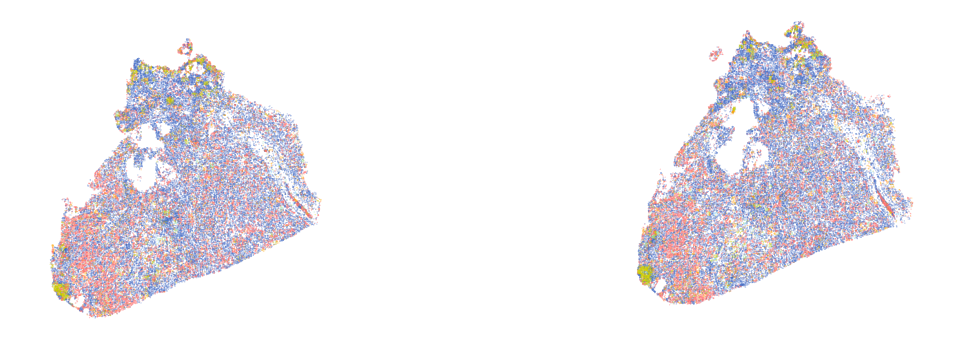

In [73]:
# cell plot
color_list = ["#3C66C4", "#CCCC00", "#FFA500", "#8FD8B8", "#87CEFA", "#FF6666"]
x_list, y_list, c_list = [], [], []
with open(cell_path, "rb") as file:
    cell_info = pkl.load(file)
for key ,value in cell_info.items():
    base_x, base_y = key.split('_')[-1].split('x')
    base_x, base_y = int(base_x), int(base_y)
    sample_name = key.split('.')[0]
    json_center, _, type_array = generate_cell_info_for_single_spot(sample_name, key, value, normalized_conditional_mat, json_dir=root_dir)
    for cell_center, cell_type in zip(json_center, type_array):
        x_list.append(cell_center[0])
        y_list.append(-cell_center[1])
        c_list.append(color_list[cell_type])

plot_height = 6
plot_width = round(plot_height * slide_width / slide_height)
plt.figure(figsize=(plot_width, plot_height))
plt.scatter(x_list, y_list, s=0.02, c=c_list)
plt.axis('off')

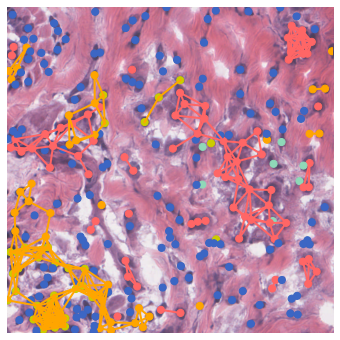

In [75]:
level_count = slide.level_count
# ROI
left, top = 46800, 17600
size = 800
dist_threshold = 75
region = slide.read_region((left, top), 0, (size, size))

x_in_list, y_in_list, c_in_list = [], [], []
for xin, yin, cin in zip(x_list, y_list, c_list):
    if left <= xin <= left+size and top <= -yin <= top+size:
        x_in_list.append(xin - left)
        y_in_list.append(-yin - top)
        c_in_list.append(cin)

plt.figure(figsize=(6, 6))
plt.scatter(x_in_list, y_in_list, s=50, c=c_in_list, zorder=2)
plt.imshow(region, alpha=0.8)
plt.axis('off')
cell_array = np.array([x_in_list, y_in_list]).T
color_array = np.array(c_in_list)
tumor_array = cell_array[color_array == '#FF6666']
cell_num = tumor_array.shape[0]
for i in range(cell_num):
    for j in range(i+1, cell_num):
        dist = np.linalg.norm(tumor_array[i] - tumor_array[j], ord=2)
        if dist < dist_threshold:
            plt.plot([tumor_array[i][0], tumor_array[j][0]], [tumor_array[i][1], tumor_array[j][1]], c='#FF6666', linewidth=2)

tumor_array = cell_array[np.logical_or(color_array == '#CCCC00', color_array == '#FFA500')]
cell_num = tumor_array.shape[0]
for i in range(cell_num):
    for j in range(i+1, cell_num):
        dist = np.linalg.norm(tumor_array[i] - tumor_array[j], ord=2)
        if dist < dist_threshold:
            plt.plot([tumor_array[i][0], tumor_array[j][0]], [tumor_array[i][1], tumor_array[j][1]], c='#FFA500', linewidth=2)